# L&T Financial Services Top-up loan 💵 Up-sell prediction


- A top-up loan is a facility of availing further funds on an existing loan

- LTFS provides it’s loan services to its customers and is interested in selling more of its Top-up loan services to its existing customers 

**Business Objective: Predict when to pitch a Top-up during the original loan tenure**


### Data 

1. Customer’s Demographics: The demography table along with the target variable & demographic information contains variables related to Frequency of the loan, Tenure of the loan, Disbursal Amount for a loan & LTV.

2. Bureau data:  Bureau data contains the behavioural and transactional attributes of the customers like current balance, Loan Amount, Overdue etc. for various tradelines of a given customer

I am a building a model given the Top-up loan bucket of 128655 customers along with demographic and bureau data to predict the right bucket/period for 14745 customers in the test data.

###  Evaluation
The evaluation metric is macro_f1_score.

**Problem Statement: It's multilabel classification.**

Let's explote different classification algorithms along with exploratory analysis of the data!!!

In [1]:
# general libraries
import os,gc
import numpy as np
import pandas as pd
from pathlib import Path

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# sklearn - metric, train test split
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
input_path = '../input/analytics-vidya-ltfs-finhack-3/'

In [2]:
input_path

'../input/analytics-vidya-ltfs-finhack-3/'

## Preprocessing of the Bureau Data

In [3]:
#Data Dictionary
data_dict = pd.read_csv(input_path+'ltfs3_demographics_dictionary.csv')
train_dict = data_dict.T.iloc[:2,:]
bureau_dict = data_dict.T.iloc[2:,:]

In [4]:
train_dict.T

,Data,Description
0,ID,Agreement ID (Dummy Value)
1,Frequency,"Frequency of the loan payment, It can be month..."
2,InstlmentMode,It can be either advance or an arrear while op...
3,LoanStatus,Active Or closed Account at this point of time
4,PaymentMode,Payement Mode at the start of loan. It can be ...
5,BranchID,This field implies the client's loan disbursin...
6,Area,Area at which the branch is present( Superset ...
7,Tenure,Tenure of the loan
8,AssetCost,Cost of asset involved of the given loan
9,AmountFinance,Most of the time its equivalent to disbursal a...


In [5]:
bureau_dict.T

,Bureau Data,Description.1,CONTRIBUTOR ID,Bank Name,Account Type,Description.2
0,ID,Agreement NO (Dummy),NBF,NBFC,A01,Auto Loan (Personal)
1,SELF-INDICATOR,This field implies whether Tradeline belong to...,COP,CO-OPERATIVE BANK,A02,Auto Overdraft
2,MATCH-TYPE,Type of match for Primary / Secondary or In ot...,MFI,NGO-MFI,A03,Two-Wheeler Loan
3,ACCT-TYPE,This field implies an account type assigned by...,HFC,HOUSING FINANCE COMPANY,A04,Commercial Vehicle Loan
4,CONTRIBUTOR-TYPE,"Whether it’s a government bank, private bank, ...",RRB,REGIONAL RURAL BANK,A05,Commercial Equipment Loan
5,DATE-REPORTED,This field implies the date up to which inform...,FRB,FOREIGN BANK,A06,Housing Loan
6,OWNERSHIP-IND,This field implies the repayment responsibility,NAB,NATIONALIZED BANK,A07,Property Loan
7,ACCOUNT-STATUS,This field displays the status of loan account.,PRB,PRIVATE BANK,A08,Loan Against Shares / Securities
8,DISBURSED-DT,This field implies the date of credit disburse...,INS,INSURANCE COMAPANY,A09,Gold Loan
9,CLOSE-DT,This field implies the date of account closure.,SBI,SBI AND ASSOCIATES,A10,Education Loan


### Concatnating train and test bureau data to save extra steps to process

In [6]:
train_bureau = pd.read_csv(input_path+"ltfs3_train_bureau.csv")
pd.set_option('display.max_colwidth',None)
train_bureau.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,1,False,PRIMARY,Overdraft,NAB,2018-04-30,Individual,Delinquent,2015-10-05,NaN,...,NaN,"37,873",0.0,Standard,"20180430,20180331,",030000,"37873,12820,","37873,,",",,",NaN
1,1,False,PRIMARY,Auto Loan (Personal),NAB,2019-12-31,Individual,Active,2018-03-19,NaN,...,F03,NaN,0.0,Standard,"20191231,20191130,20191031,20190930,20190831,20190731,20190630,20190531,20190430,20190331,20190228,20190131,20181231,20181130,20181031,20180930,20180831,20180731,20180630,20180531,20180430,20180331,",000000000000000000000000000000000000000000000000000000000000011000,"20797,21988,23174,24341,25504,26648,27780,28910,30020,31128,32267,33427,34547,35655,36764,37850,38939,40004,41059,42118,44601,44181,",",,,,,,,,,,,,,,,,,,,,1452,,",",,,,,,,,,,,,,,,,,,,,,,",36.0
2,1,True,PRIMARY,Tractor Loan,NBF,2020-01-31,Individual,Active,2019-08-30,NaN,...,NaN,0,0.0,NaN,"20200131,20191231,20191130,20191031,20190930,20190831,",000000000000000000,"116087,116087,145000,145000,145000,145000,","0,0,0,0,0,0,",",,,,,,",NaN
3,1,True,PRIMARY,Auto Loan (Personal),NBF,2017-09-30,Individual,Closed,2013-09-27,2017-09-21 00:00:00,...,NaN,0,0.0,NaN,"20170930,20170801,20170731,20170630,20170531,20170430,20170331,20170228,20170131,20161231,20161130,20161031,20160930,20160831,20160731,20160630,20160531,20160430,20160331,20160229,20160131,20151231,20151130,20151031,20150930,20150831,20150731,20150630,20150531,20150430,20150331,20150228,20150131,20141231,20141130,20141031,",000DDD027026027026027024027027000032000000000000000026027025027027026027026027027026027000000000000000000000,"0,,15925,23754,31494,39147,46713,54194,61590,68903,68903,76133,83281,90348,97336,104245,111076,124506,131108,137635,144088,150468,156776,163013,169180,175277,181305,187265,193157,198983,204743,210438,216069,221636,227140,232582,","0,,1014,1014,1014,1014,1014,1014,1014,983,0,927,0,0,0,0,0,778,754,734,712,691,671,651,633,615,597,580,565,0,0,0,0,0,0,0",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,1,True,PRIMARY,Tractor Loan,NBF,2016-02-29,Individual,Closed,2012-02-10,2016-02-01 00:00:00,...,NaN,0,0.0,NaN,"20160229,20160131,20151231,20151130,20151031,20150930,20150831,20150731,20150630,20150531,20150430,20150331,20150228,20150131,20141231,20141130,20141031,20140930,20140831,20140731,20140630,20140531,20140430,20140331,20140228,20140131,20131231,20131130,20131031,20130930,20130831,20130731,20130630,20130531,20130430,20130331,",000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,"0,0,23658,23321,22989,46321,45662,45012,68030,67062,66108,88826,87562,86316,108747,107200,105675,127830,126012,124219,146111,144033,141984,163623,161295,159001,180398,177832,175302,196467,193672,190917,211860,208846,205875,226605,","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN


In [7]:
train_bureau.shape

(560844, 25)

In [8]:
test_bureau = pd.read_csv(input_path+"ltfs3_test_bureau.csv")
pd.set_option('display.max_colwidth',None)
test_bureau.head()

,ID,SELF-INDICATOR,MATCH-TYPE,ACCT-TYPE,CONTRIBUTOR-TYPE,DATE-REPORTED,OWNERSHIP-IND,ACCOUNT-STATUS,DISBURSED-DT,CLOSE-DT,...,INSTALLMENT-FREQUENCY,OVERDUE-AMT,WRITE-OFF-AMT,ASSET_CLASS,REPORTED DATE - HIST,DPD - HIST,CUR BAL - HIST,AMT OVERDUE - HIST,AMT PAID - HIST,TENURE
0,4,False,PRIMARY,Credit Card,CCC,2019-11-17,Individual,Active,2019-09-26,NaN,...,NaN,0,0.0,NaN,"20191117,",000,"589,","0,","0,",NaN
1,4,False,PRIMARY,Housing Loan,HFC,2019-10-31,Joint,Active,2017-06-21,NaN,...,F03,0,0.0,NaN,"20191031,20190930,20190831,20190731,20190630,20190531,20190430,20190331,20190228,20190131,20181231,20181130,20181031,20180930,20180831,20180731,20180630,20180531,20180430,20180331,20180228,20180131,20171231,20171130,20171031,20170930,20170831,20170731,20170630,",000000000000000000000000000000000000000000000000000000000000000000000000000000031030020,"2107227,2122196,2136877,2151448,2165910,2180264,2194511,2208651,2222685,2236614,2250439,2264348,2278154,2291858,2306032,2320105,2334077,2348143,2362110,2375978,2390144,2404212,2418182,2432056,2445834,2459517,2504848,2517396,2503778,","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31743,30797,3778,",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,",120.0
2,4,False,PRIMARY,Property Loan,HFC,2019-10-31,Joint,Active,2017-06-27,NaN,...,F03,0,0.0,NaN,"20191031,20190930,20190831,20190731,20190630,20190531,20190430,20190331,20190228,20190131,20181231,20181130,20181031,20180930,20180831,20180731,20180630,20180531,20180430,20180331,20180228,20180131,20171231,20171130,20171031,20170930,20170831,20170731,20170630,",000000000000000000000000000000000000000000000000000000000000000000000000000000000030030,"83458,84051,84632,85209,85781,86349,86913,87473,88028,88579,89126,89676,90222,90764,91325,91882,92435,92992,93545,94094,94654,95211,95764,96313,96858,97399,97936,98562,99092,","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,92,",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,",120.0
3,4,True,PRIMARY,Tractor Loan,NBF,2015-10-31,Individual,Closed,2011-12-29,2015-10-13 00:00:00,...,NaN,0,0.0,NaN,"20151031,20150901,20150831,20150731,20150630,20150531,20150430,20150331,20150228,20150131,20141231,20141130,20141031,20140930,20140831,20140731,20140630,20140531,20140430,20140331,20140228,20140131,20131231,20131130,20131031,20130930,20130831,20130731,20130630,20130531,20130430,20130331,20130228,20130131,20121231,20121130,",000DDD027000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000,"0,,21548,32097,42500,52758,62874,72850,82688,92389,101956,111390,120694,129869,138917,147839,156637,165314,173870,182308,190629,198834,206926,214905,222774,230534,238186,245732,253174,260512,267749,274885,281923,288863,295707,302456,","0,,11000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,",NaN
4,5,False,PRIMARY,Gold Loan,PRB,2017-08-31,Individual,Closed,2016-05-04,2017-06-15 00:00:00,...,NaN,0,0.0,NaN,"20170630,20170501,20170401,20170331,20170201,20170101,20161231,20161101,20161001,20160930,20160801,20160701,20160630,",000DDDDDD000DDDDDD000DDDDDD000DDDDDD000,"0,,,25846,,,25846,,,25846,,,25846,","0,,,0,,,0,,,0,,,0",",,,,,,,,,,,,,,",NaN


In [9]:
test_bureau.shape

(64019, 25)

In [10]:
train_bureau = train_bureau.drop_duplicates()
test_bureau  = test_bureau.drop_duplicates()

In [11]:
# add extra column for 'train' and 'test'
train_bureau['source'] = 'train'
test_bureau['source']  = 'test'

In [12]:
train_bureau.columns

Index(['ID', 'SELF-INDICATOR', 'MATCH-TYPE', 'ACCT-TYPE', 'CONTRIBUTOR-TYPE',
       'DATE-REPORTED', 'OWNERSHIP-IND', 'ACCOUNT-STATUS', 'DISBURSED-DT',
       'CLOSE-DT', 'LAST-PAYMENT-DATE', 'CREDIT-LIMIT/SANC AMT',
       'DISBURSED-AMT/HIGH CREDIT', 'INSTALLMENT-AMT', 'CURRENT-BAL',
       'INSTALLMENT-FREQUENCY', 'OVERDUE-AMT', 'WRITE-OFF-AMT', 'ASSET_CLASS',
       'REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST',
       'AMT OVERDUE - HIST', 'AMT PAID - HIST', 'TENURE', 'source'],
      dtype='object')

In [13]:
for col in train_bureau.columns:
    if train_bureau[col].dtype=='object':
        print(train_bureau[col].value_counts())
        print('')

PRIMARY      556783
SECONDARY       197
Name: MATCH-TYPE, dtype: int64

Tractor Loan                                                           186117
Gold Loan                                                               90817
Business Loan Priority Sector  Agriculture                              79918
Kisan Credit Card                                                       33340
Auto Loan (Personal)                                                    29518
Other                                                                   25513
Commercial Vehicle Loan                                                 18731
Two-Wheeler Loan                                                        15795
Credit Card                                                             12406
Consumer Loan                                                           12035
Overdraft                                                                8926
Personal Loan                                                         

In [14]:
bureau = pd.concat([train_bureau, test_bureau])

In [15]:
del train_bureau,test_bureau
gc.collect()

66

### Merging similar columns into single column for ease

In [16]:
# ACCT-TYPE
bureau['ACCT-TYPE'] = bureau['ACCT-TYPE'].replace(bureau['ACCT-TYPE'].value_counts()[bureau['ACCT-TYPE'].value_counts()/bureau.shape[0]*100<3].index, 'Rest')
bureau['ACCT-TYPE'].value_counts()

Tractor Loan                                  207869
Rest                                          104883
Gold Loan                                      98370
Business Loan Priority Sector  Agriculture     88083
Kisan Credit Card                              37588
Auto Loan (Personal)                           33432
Other                                          29602
Commercial Vehicle Loan                        20484
Name: ACCT-TYPE, dtype: int64

In [17]:
# CONTRIBUTOR-TYPE - # Replace to merge similar values
bureau['CONTRIBUTOR-TYPE'] = bureau['CONTRIBUTOR-TYPE'].replace(['HFC', 'MFI', 'FRB','SFB', 'ARC', 'OFI' ,'CCC'], 'OTHERS')
bureau['CONTRIBUTOR-TYPE'].value_counts()

NBF       285776
NAB       190914
PRB        83567
RRB        26315
COP        24203
OTHERS      9536
Name: CONTRIBUTOR-TYPE, dtype: int64

In [18]:
# Replacing with similar values

bureau['ACCOUNT-STATUS'] = bureau['ACCOUNT-STATUS'].replace(['SUIT FILED (WILFUL DEFAULT)','Written Off', 'Suit Filed', 'Restructured', 'Settled',
                                                             'WILFUL DEFAULT', 'Cancelled', 'Sold/Purchased'], 'Written Off')
bureau['ACCOUNT-STATUS'].value_counts()

Closed         351441
Active         225266
Delinquent      36883
Written Off      6721
Name: ACCOUNT-STATUS, dtype: int64

## Checking NA values and replace with 0 or max

In [19]:
# drop columns with greater than 20% null values
bureau.drop(bureau.isnull().sum()[bureau.isnull().sum()/bureau.shape[0]*100>20].index, axis=1, inplace=True)

In [20]:
bureau['DISBURSED-DT']  = pd.to_datetime(bureau['DISBURSED-DT'])
bureau['DATE-REPORTED'] = pd.to_datetime(bureau['DATE-REPORTED'])

bureau['DATE-REPORTED'].max(), bureau['DISBURSED-DT'].max()

(Timestamp('2020-08-08 00:00:00'), Timestamp('2020-02-11 00:00:00'))

In [21]:
bureau.isnull().sum()

ID                               0
SELF-INDICATOR                   0
MATCH-TYPE                       0
ACCT-TYPE                        0
CONTRIBUTOR-TYPE                 0
DATE-REPORTED                 3677
OWNERSHIP-IND                    0
ACCOUNT-STATUS                   0
DISBURSED-DT                 31927
DISBURSED-AMT/HIGH CREDIT       38
CURRENT-BAL                    264
WRITE-OFF-AMT                21623
REPORTED DATE - HIST         21623
DPD - HIST                   22081
CUR BAL - HIST               21623
AMT OVERDUE - HIST           21623
AMT PAID - HIST              22900
source                           0
dtype: int64

In [22]:
bureau['DATE-REPORTED'] = bureau['DATE-REPORTED'].fillna(bureau['DATE-REPORTED'].max())
bureau['DISBURSED-DT']  = bureau['DISBURSED-DT'].fillna(bureau['DATE-REPORTED'])

In [23]:
bureau.drop('MATCH-TYPE', axis=1, inplace=True)

In [24]:
bureau = bureau.drop(['REPORTED DATE - HIST', 'DPD - HIST', 'CUR BAL - HIST','AMT OVERDUE - HIST', 'AMT PAID - HIST'], axis=1) # may be useful later

In [25]:
# split the data by whitespace

bureau['CURRENT-BAL']               = bureau['CURRENT-BAL'].apply(lambda x: str(x).replace(',', ''))
bureau['DISBURSED-AMT/HIGH CREDIT'] = bureau['DISBURSED-AMT/HIGH CREDIT'].apply(lambda x: str(x).replace(',', ''))
bureau['WRITE-OFF-AMT']             = bureau['WRITE-OFF-AMT'].apply(lambda x: str(x).replace(',', ''))

In [26]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 620311 entries, 0 to 64018
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   ID                         620311 non-null  int64         
 1   SELF-INDICATOR             620311 non-null  bool          
 2   ACCT-TYPE                  620311 non-null  object        
 3   CONTRIBUTOR-TYPE           620311 non-null  object        
 4   DATE-REPORTED              620311 non-null  datetime64[ns]
 5   OWNERSHIP-IND              620311 non-null  object        
 6   ACCOUNT-STATUS             620311 non-null  object        
 7   DISBURSED-DT               620311 non-null  datetime64[ns]
 8   DISBURSED-AMT/HIGH CREDIT  620311 non-null  object        
 9   CURRENT-BAL                620311 non-null  object        
 10  WRITE-OFF-AMT              620311 non-null  object        
 11  source                     620311 non-null  object   

In [27]:
# convert to float type these columns
bureau.columns[-4:-1]

Index(['DISBURSED-AMT/HIGH CREDIT', 'CURRENT-BAL', 'WRITE-OFF-AMT'], dtype='object')

In [28]:
for col in bureau.columns[-4:-1]:
    print(col)
    bureau[col] = bureau[col].replace('nan', 0)
    bureau[col] = bureau[col].apply(lambda x: float(x))

DISBURSED-AMT/HIGH CREDIT
CURRENT-BAL
WRITE-OFF-AMT


In [29]:
# no nill values 
bureau.isnull().sum()

ID                           0
SELF-INDICATOR               0
ACCT-TYPE                    0
CONTRIBUTOR-TYPE             0
DATE-REPORTED                0
OWNERSHIP-IND                0
ACCOUNT-STATUS               0
DISBURSED-DT                 0
DISBURSED-AMT/HIGH CREDIT    0
CURRENT-BAL                  0
WRITE-OFF-AMT                0
source                       0
dtype: int64

In [30]:
bureau = pd.get_dummies(data=bureau, columns=['ACCT-TYPE', 'OWNERSHIP-IND', 'CONTRIBUTOR-TYPE','ACCOUNT-STATUS'])
bureau.head()

,ID,SELF-INDICATOR,DATE-REPORTED,DISBURSED-DT,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,WRITE-OFF-AMT,source,ACCT-TYPE_Auto Loan (Personal),ACCT-TYPE_Business Loan Priority Sector Agriculture,...,CONTRIBUTOR-TYPE_COP,CONTRIBUTOR-TYPE_NAB,CONTRIBUTOR-TYPE_NBF,CONTRIBUTOR-TYPE_OTHERS,CONTRIBUTOR-TYPE_PRB,CONTRIBUTOR-TYPE_RRB,ACCOUNT-STATUS_Active,ACCOUNT-STATUS_Closed,ACCOUNT-STATUS_Delinquent,ACCOUNT-STATUS_Written Off
0,1,False,2018-04-30,2015-10-05,37352.0,37873.0,0.0,train,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,False,2019-12-31,2018-03-19,44000.0,20797.0,0.0,train,1,0,...,0,1,0,0,0,0,1,0,0,0
2,1,True,2020-01-31,2019-08-30,145000.0,116087.0,0.0,train,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,True,2017-09-30,2013-09-27,300000.0,0.0,0.0,train,1,0,...,0,0,1,0,0,0,0,1,0,0
4,1,True,2016-02-29,2012-02-10,275000.0,0.0,0.0,train,0,0,...,0,0,1,0,0,0,0,1,0,0


In [31]:
bureau_data = bureau.groupby(['ID', 'source']).sum().reset_index()
bureau_data.to_csv('bureau_data.csv', index=False)

In [32]:
bureau_data.head()

,ID,source,SELF-INDICATOR,DISBURSED-AMT/HIGH CREDIT,CURRENT-BAL,WRITE-OFF-AMT,ACCT-TYPE_Auto Loan (Personal),ACCT-TYPE_Business Loan Priority Sector Agriculture,ACCT-TYPE_Commercial Vehicle Loan,ACCT-TYPE_Gold Loan,...,CONTRIBUTOR-TYPE_COP,CONTRIBUTOR-TYPE_NAB,CONTRIBUTOR-TYPE_NBF,CONTRIBUTOR-TYPE_OTHERS,CONTRIBUTOR-TYPE_PRB,CONTRIBUTOR-TYPE_RRB,ACCOUNT-STATUS_Active,ACCOUNT-STATUS_Closed,ACCOUNT-STATUS_Delinquent,ACCOUNT-STATUS_Written Off
0,1,train,5,2201352.0,618526.0,0.0,5,0,0,0,...,0,4,5,0,0,0,3,5,1,0
1,2,train,1,18117081.0,10349457.0,0.0,1,0,4,0,...,0,0,7,0,6,0,7,6,0,0
2,3,train,2,3708369.0,2065165.0,0.0,0,0,3,8,...,4,1,11,2,13,0,11,19,1,0
3,4,test,1,2964588.0,2191274.0,0.0,0,0,0,0,...,0,0,1,3,0,0,3,1,0,0
4,5,test,1,1939813.0,907231.0,0.0,0,0,0,3,...,0,0,3,2,3,0,2,6,0,0


In [33]:
bureau_data.shape

(143400, 29)

In [34]:
gc.collect()

44

## Preprocessing of the train and test data

### train data/test data

In [35]:
train = pd.read_csv(input_path+'ltfs3_train.csv')
pd.set_option('display.max_colwidth',None)
train.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE,Top-up Month
0,1,Monthly,Arrear,Closed,PDC_E,1,NaN,48,450000,275000.0,...,1568,21946,61.11,M,49.0,35833.33,RAISEN,MADHYA PRADESH,464993.0,> 48 Months
1,2,Monthly,Advance,Closed,PDC,333,BHOPAL,47,485000,350000.0,...,1062,34802,70.00,M,23.0,666.67,SEHORE,MADHYA PRADESH,466001.0,No Top-up Service
2,3,Quatrly,Arrear,Active,Direct Debit,1,NaN,68,690000,519728.0,...,1060,127335,69.77,M,39.0,45257.00,BHOPAL,MADHYA PRADESH,462030.0,12-18 Months
3,7,Monthly,Advance,Closed,Billed,125,GUNA,48,480000,400000.0,...,1060,25094,80.92,M,24.0,20833.33,ASHOK NAGAR,MADHYA PRADESH,473335.0,> 48 Months
4,8,Monthly,Arrear,Closed,Billed,152,BILASPUR,44,619265,440000.0,...,1046,21853,71.05,M,56.0,27313.67,BILASPUR,CHATTISGARH,495442.0,36-48 Months


In [36]:
test = pd.read_csv(input_path+'ltfs3_test.csv')
pd.set_option('display.max_colwidth',None)
test.head()

,ID,Frequency,InstlmentMode,LoanStatus,PaymentMode,BranchID,Area,Tenure,AssetCost,AmountFinance,...,AssetID,ManufacturerID,SupplierID,LTV,SEX,AGE,MonthlyIncome,City,State,ZiPCODE
0,4,Monthly,Advance,Closed,PDC_E,2,GUNA,46,480000,365000.0,...,3524747,1046.0,22354,75.83,M,50.0,32069.00,GUNA,MADHYA PRADESH,473001.0
1,5,Monthly,Advance,Closed,PDC,2,GUNA,45,480000,285000.0,...,4985862,1046.0,22354,57.44,M,35.0,25000.00,GUNA,MADHYA PRADESH,473001.0
2,6,Quatrly,Arrear,Closed,PDC,2,GUNA,48,580000,400000.0,...,12881783,1060.0,65929,68.97,M,37.0,23333.33,GUNA,MADHYA PRADESH,473001.0
3,25,Half Yearly,Arrear,Closed,Billed,154,NaN,36,725000,500000.0,...,10613776,1049.0,68597,61.79,M,55.0,91666.67,MAHASAMUND,CHATTISGARH,493558.0
4,119,Quatrly,Arrear,Closed,PDC,194,CUTTACK,48,617000,400000.0,...,7911110,1049.0,38493,59.09,M,48.0,12500.00,JAGATSINGHAPUR,ORISSA,754137.0


In [37]:
gc.collect()

22

In [38]:
# drop unwanted columns
train.drop(columns=["Area","City","BranchID","ZiPCODE","ManufacturerID",'SupplierID', 'AssetID'],inplace=True)
# drop unwanted columns
test.drop(columns=["Area","City","BranchID","ZiPCODE","ManufacturerID",'SupplierID', 'AssetID'],inplace=True)

In [39]:
# value counts for all columns
for col in train.columns:
    if train[col].dtype=='object':
        print(train[col].value_counts())
        print('')

Half Yearly    76248
Monthly        31150
Quatrly        20795
BI-Monthly       462
Name: Frequency, dtype: int64

Arrear     122349
Advance      6306
Name: InstlmentMode, dtype: int64

Closed    94457
Active    34198
Name: LoanStatus, dtype: int64

Direct Debit    31766
ECS             31390
PDC             26617
Billed          26486
PDC_E            9937
Auto Debit        843
SI Reject         744
Cheque            442
ECS Reject        417
Escrow              7
PDC Reject          6
Name: PaymentMode, dtype: int64

2017-10-31    1287
2017-06-30    1166
2017-09-30     725
2016-10-31     661
2018-03-31     656
              ... 
2014-07-05       1
2019-10-20       1
2015-10-02       1
2010-05-08       1
2010-02-01       1
Name: DisbursalDate, Length: 2837, dtype: int64

2018-06-10    2298
2017-06-10    2217
2019-06-10    2195
2017-12-10    2185
2021-06-10    2180
              ... 
2014-03-07       1
2013-03-02       1
2014-06-28       1
2011-04-29       1
2015-03-11       1
Name: Ma

In [40]:
train['State'] = train['State'].replace(train['State'].value_counts()[train['State'].value_counts()/train.shape[0]*100<3].index, 'Others')
train['State'].value_counts()

test['State'] = test['State'].replace(test['State'].value_counts()[test['State'].value_counts()/test.shape[0]*100<3].index, 'Others')
test['State'].value_counts()

MADHYA PRADESH    3373
RAJASTHAN         2740
MAHARASHTRA       1489
ANDHRA PRADESH    1411
GUJARAT           1085
Others            1067
HARYANA            994
KARNATAKA          829
PUNJAB             723
UTTARAKHAND        589
UTTAR PRADESH      445
Name: State, dtype: int64

In [41]:
train['PaymentMode'] = train['PaymentMode'].replace(train['PaymentMode'].value_counts()[train['PaymentMode'].value_counts()/train.shape[0]*100<3].index, 'Others')
test['PaymentMode'] = test['PaymentMode'].replace(test['PaymentMode'].value_counts()[test['PaymentMode'].value_counts()/test.shape[0]*100<3].index, 'Others')
train['PaymentMode'].value_counts()

Direct Debit    31766
ECS             31390
PDC             26617
Billed          26486
PDC_E            9937
Others           2459
Name: PaymentMode, dtype: int64

In [42]:
train['DisbursalDate'] = pd.to_datetime(train['DisbursalDate'])
train['MaturityDAte']  = pd.to_datetime(train['MaturityDAte'])
train['AuthDate']      = pd.to_datetime(train['AuthDate'])
# test
test['DisbursalDate']  = pd.to_datetime(test['DisbursalDate'])
test['MaturityDAte']   = pd.to_datetime(test['MaturityDAte'])
test['AuthDate']       = pd.to_datetime(test['AuthDate'])

In [43]:
train['MonthlyIncome']  = train['MonthlyIncome'].fillna(0)
train['MaturityDAte']   = train['MaturityDAte'].fillna(train['MaturityDAte'].mode()[0])
#test
test['MonthlyIncome']   = test['MonthlyIncome'].fillna(0)
test['MaturityDAte']    = test['MaturityDAte'].fillna(test['MaturityDAte'].mode()[0])

In [44]:
train['AGE'] = train['AGE'].fillna(train['AGE'].mode()[0])
test['AGE']  = test['AGE'].fillna(test['AGE'].mode()[0])

In [45]:
train.drop(['DisbursalDate',"SEX",'MaturityDAte', 'AuthDate'], axis=1, inplace=True)
test.drop(['DisbursalDate', "SEX",'MaturityDAte', 'AuthDate'], axis=1, inplace=True)

In [46]:
print(train.isnull().sum())

ID                 0
Frequency          0
InstlmentMode      0
LoanStatus         0
PaymentMode        0
Tenure             0
AssetCost          0
AmountFinance      0
DisbursalAmount    0
EMI                0
LTV                0
AGE                0
MonthlyIncome      0
State              0
Top-up Month       0
dtype: int64


In [47]:
train['YearsOfService']   = 60 - train['AGE']
test['YearsOfService']   = 60 - test['AGE']

train.drop('AGE', 1, inplace=True)
test.drop('AGE', 1, inplace=True)

In [48]:
train.to_csv('cleaned_train.csv', index=False)
test.to_csv('cleaned_test.csv', index=False)

In [49]:
gc.collect()

123

### Data Processed!

## Label the target class

In [50]:
train = pd.read_csv('cleaned_train.csv')
test = pd.read_csv('cleaned_test.csv')

In [51]:
from sklearn import preprocessing

categories = train.pop("Top-up Month")
le = preprocessing.LabelEncoder()
le.fit(categories)
y = le.transform(categories)

print("Number of Targets:",len(y))
print("Number of Samples:", len(train))

Number of Targets: 128655
Number of Samples: 128655


## Split the data

In [52]:
train = train.drop(['ID'], 1)
test  = test.drop(['ID'], 1)

In [53]:
from sklearn.model_selection import train_test_split

X = train

X_train,X_val,y_train,y_val = train_test_split(X, y,test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)

(102924, 13) (102924,)


In [54]:
!pip install pycaret

     |████████████████████████████████| 261 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 101 kB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 14.2 MB 38.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 26.3 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 1.5 MB/s  eta 0:00:01
     |████████████████████████████████| 370 kB 32.5 MB/s eta 0:00:01
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158155 sha256=70beb2fd1b826a54fd432e525395f111f1971632569c06ea821161bdde01e000
  Stored in directory: /root/.cache/pip/wheels/be/5d/0a/9e13f53f4f5dfb67cd8d245bb7cdffe12f135846f491a283e3
  Created wheel for databricks-cli: filename=databricks_cli-0.14.3-py3-none-any.whl size=100555 sha256=eebffc3f5f747e02915de738081c8303826f022d29c4f3a88e7aa5ad41cb1ef7
  Stored in directory: /root/.cache/pip/wheels/3b/60/14/6930445b08959fbdf4e3029bac7e1f2cccb2e94df8afa00b29
  Created wheel for gunicorn: filename=gunicorn-2

In [55]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from pycaret.classification import *

In [56]:
gc.collect()

0

### Train the data with PyCaret Classification Module

In [57]:
train = pd.read_csv('cleaned_train.csv')
train = train.drop(['ID'], 1)

In [58]:
clf = pycaret.classification.setup(data = train,target ='Top-up Month', session_id=14)

,Description,Value
0,session_id,14
1,Target,Top-up Month
2,Target Type,Multiclass
3,Label Encoded,"> 48 Months: 0, 12-18 Months: 1, 18-24 Months: 2, 24-30 Months: 3, 30-36 Months: 4, 36-48 Months: 5, No Top-up Service: 6"
4,Original Data,"(128655, 14)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [59]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsClassifier,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDClassifier,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessClassifier,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron.MLPClassifier,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [ ]:
#best_model = compare_models(exclude = ['knn','lr','nb','ridge','qda','lda','et','ada','rbfsvm','svm','dt','gbc','mlp','gpc','lightgbm'])

In [63]:
gc.collect()

148

In [66]:
# stacking models
# create individual models for stacking
#xgboost = create_model('xgboost')
#rf = create_model('rf')
catboost = create_model('catboost')
#model = blend_models(['xgboost','rf','catboost'])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8281,0.6952,0.1445,0.7181,0.7519,0.0064,0.0317
1,0.8287,0.7028,0.1476,0.7530,0.7537,0.0141,0.0573
2,0.8283,0.6928,0.1454,0.7575,0.7526,0.0109,0.0480
3,0.8280,0.6940,0.1468,0.7407,0.7525,0.0110,0.0446
4,0.8273,0.7040,0.1454,0.7264,0.7522,0.0090,0.0341
5,0.8281,0.6992,0.1445,0.7318,0.7520,0.0082,0.0384
6,0.8281,0.7069,0.1464,0.7539,0.7528,0.0116,0.0472
7,0.8284,0.7037,0.1469,0.7599,0.7527,0.0110,0.0494
8,0.8274,0.7025,0.1448,0.7395,0.7515,0.0052,0.0227
9,0.8274,0.6868,0.1482,0.7518,0.7525,0.0108,0.0391


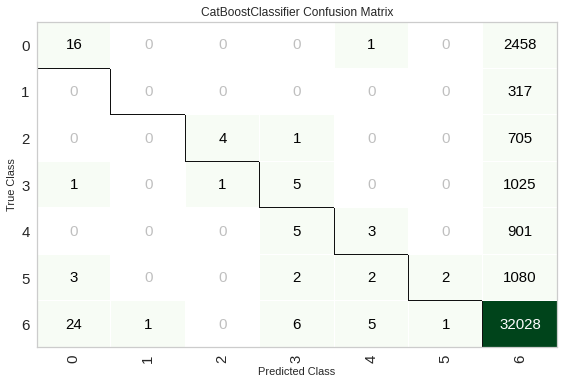

In [65]:
# plotting a model
plot_model(catboost,plot = 'confusion_matrix')

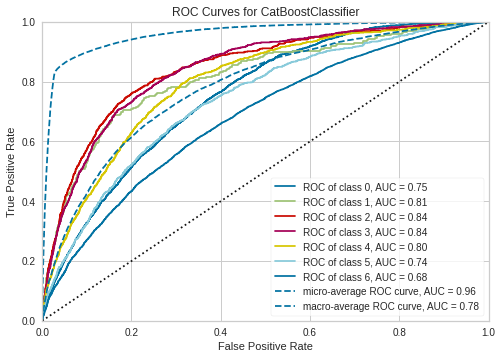

In [67]:
# plotting AUC Curve
plot_model(catboost, plot = 'auc')

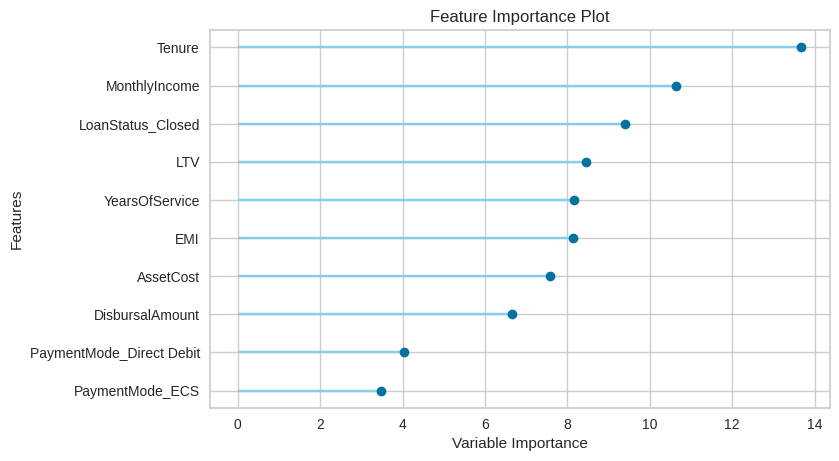

In [69]:
# feature importance plot
plot_model(catboost, plot='feature')

### Predict on test/hold-out data

In [71]:
predict_model(catboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8306,0.6981,0.1458,0.7612,0.7555,0.0088,0.0418


,Tenure,AssetCost,DisbursalAmount,EMI,LTV,MonthlyIncome,YearsOfService,Frequency_BI-Monthly,Frequency_Half Yearly,Frequency_Monthly,...,State_MADHYA PRADESH,State_MAHARASHTRA,State_Others,State_PUNJAB,State_RAJASTHAN,State_UTTAR PRADESH,State_WEST BENGAL,Top-up Month,Label,Score
0,33.0,523000.0,400000.0,87900.0,76.480003,60416.671875,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30-36 Months,No Top-up Service,0.7333
1,65.0,560000.0,435000.0,32250.0,77.680000,45666.671875,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36-48 Months,No Top-up Service,0.8120
2,36.0,465000.0,300000.0,33775.0,57.250000,41666.671875,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No Top-up Service,No Top-up Service,0.9201
3,66.0,665000.0,504895.0,7500.0,74.800003,83333.328125,19.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.8166
4,36.0,450000.0,275000.0,67856.0,61.110001,18750.000000,-3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38592,68.0,520000.0,350000.0,26800.0,62.150002,45583.328125,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No Top-up Service,No Top-up Service,0.8633
38593,48.0,550000.0,401942.0,67700.0,73.080002,15000.000000,28.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.8642
38594,36.0,653323.0,251385.0,51800.0,38.480000,29166.669922,21.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No Top-up Service,No Top-up Service,0.8904
38595,48.0,529000.0,420000.0,38325.0,72.150002,41333.328125,15.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.7944


### Finalize the model

In [73]:
final_model = finalize_model(catboost)
predict_model(final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8342,0.7740,0.1636,0.8452,0.7625,0.0383,0.1335


,Tenure,AssetCost,DisbursalAmount,EMI,LTV,MonthlyIncome,YearsOfService,Frequency_BI-Monthly,Frequency_Half Yearly,Frequency_Monthly,...,State_MADHYA PRADESH,State_MAHARASHTRA,State_Others,State_PUNJAB,State_RAJASTHAN,State_UTTAR PRADESH,State_WEST BENGAL,Top-up Month,Label,Score
0,33.0,523000.0,400000.0,87900.0,76.480003,60416.671875,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30-36 Months,No Top-up Service,0.7539
1,65.0,560000.0,435000.0,32250.0,77.680000,45666.671875,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36-48 Months,No Top-up Service,0.7106
2,36.0,465000.0,300000.0,33775.0,57.250000,41666.671875,29.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No Top-up Service,No Top-up Service,0.9221
3,66.0,665000.0,504895.0,7500.0,74.800003,83333.328125,19.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.8388
4,36.0,450000.0,275000.0,67856.0,61.110001,18750.000000,-3.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.9508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38592,68.0,520000.0,350000.0,26800.0,62.150002,45583.328125,28.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,No Top-up Service,No Top-up Service,0.8432
38593,48.0,550000.0,401942.0,67700.0,73.080002,15000.000000,28.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.8513
38594,36.0,653323.0,251385.0,51800.0,38.480000,29166.669922,21.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No Top-up Service,No Top-up Service,0.8981
38595,48.0,529000.0,420000.0,38325.0,72.150002,41333.328125,15.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No Top-up Service,No Top-up Service,0.7879


### Saving the Model

In [74]:
save_model(final_model,'ltfs3_catboost_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Top-up Month',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_...
                 ('cluster_all', 'passthrough'),
                 ('dummy', Dummify(target='Top-up Month')),
                 ('fix_perfect', Remove_100(target='Top-up Month')),
                 ('clean_names', Clean_Colum_Names()),
 

In [75]:
best_params = final_model.get_all_params()
print(best_params)

{'nan_mode': 'Min', 'eval_metric': 'MultiClass', 'iterations': 1000, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'use_best_model': False, 'class_names': [0, 1, 2, 3, 4, 5, 6], 'random_seed': 14, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'bagging_temperature': 1, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'MultiClass', 'learning_rate': 0.10136900097131728, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 1, 'bootstrap_type': 'Bayes

In [76]:
gc.collect()

44

In [77]:
test = pd.read_csv('cleaned_test.csv')
ID =test.ID
test = test.drop(['ID'], 1)
preds = predict_model(final_model,data=test).Label
submission = pd.DataFrame({"ID":ID,"Top-up Month":preds})

In [78]:
submission.to_csv('submission_ltfs3.csv',index=False)

In [79]:
submission.head()

,ID,Top-up Month
0,4,No Top-up Service
1,5,No Top-up Service
2,6,No Top-up Service
3,25,No Top-up Service
4,119,No Top-up Service
